In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.features import rasterize
from rasterio import features

import geopandas as gpd
from shapely.geometry import box, shape
from pyproj import Transformer, CRS

import cv2
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects, remove_small_holes

import tensorflow as tf
from tensorflow.keras import layers, Model

# -----------------------------
# CONFIG (edit this section)
# -----------------------------
IMAGE_PATH = "sr.tif"          # any georeferenced GeoTIFF
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Bands to use (1-based indexing for GeoTIFF). If None -> use first 3 available.
BANDS = None                   # e.g. [1,2,3] or [4,3,2] etc.

# Download footprints
BUFFER_DEG = 0.005             # buffer around image bbox (degrees)
FOOTPRINT_SOURCE = "auto"      # "auto" | "overture" | "osm"

# Mask settings
RASTERIZE_ALL_TOUCHED = False  # False is usually cleaner (less merging)
LABEL_DILATE_PIXELS = 0        # try 1-2 if footprints slightly smaller than roofs

# Training settings
PATCH_SIZE = 256
N_PATCHES = 1200               # increase if you can
POS_FRACTION = 0.6             # % of patches centered on buildings
MIN_POS_RATIO = 0.01           # positive patch must contain >= this fraction of building pixels
MAX_NEG_RATIO = 0.001          # negative patch must contain <= this fraction of building pixels

BATCH_SIZE = 8
EPOCHS = 40
LR = 1e-4
SEED = 42

# Inference settings (overlap blending)
TILE_SIZE = PATCH_SIZE
STRIDE = PATCH_SIZE // 2       # overlap = 50%
PRED_THRESHOLD = 0.5           # will be auto-tuned if GT exists

# Postprocess
MIN_OBJECT_PIXELS = 40
HOLE_PIXELS = 80
USE_WATERSHED_SPLIT = True     # optional: split merged blobs
WATERSHED_MIN_DISTANCE = 6     # bigger = fewer splits

# Model save
MODEL_PATH = os.path.join(OUTPUT_DIR, "unet_buildings.keras")

np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Config loaded")
print("Image:", IMAGE_PATH)
print("Output:", OUTPUT_DIR)


✅ Config loaded
Image: sr.tif
Output: outputs


✅ Image loaded: (512, 512, 3)
CRS: EPSG:32734
Bounds: BoundingBox(left=301418.5322976671, bottom=6239058.947444493, right=302698.5322976671, top=6240338.947444493)


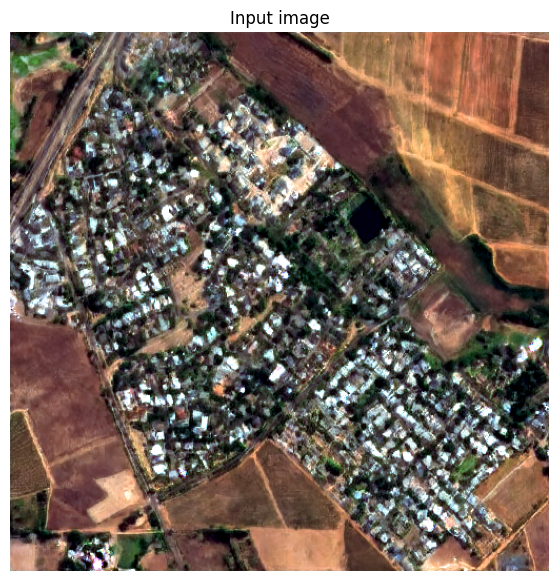

In [2]:
def percentile_normalize(img, pmin=2, pmax=98, eps=1e-6):
    """
    Robust per-band normalization to [0,1] using percentiles.
    Works for uint8, uint16, float, Sentinel-style ranges, etc.
    img: (H,W,C)
    """
    img = img.astype(np.float32)
    out = np.zeros_like(img, dtype=np.float32)
    for c in range(img.shape[2]):
        band = img[..., c]
        lo = np.percentile(band, pmin)
        hi = np.percentile(band, pmax)
        if hi - lo < eps:
            out[..., c] = 0.0
        else:
            out[..., c] = (band - lo) / (hi - lo)
    return np.clip(out, 0, 1)


def load_geotiff_rgb(path, bands=None):
    """
    Load a GeoTIFF and return:
      img (H,W,3) float32 in [0,1],
      profile, crs, transform, bounds
    """
    with rasterio.open(path) as src:
        profile = src.profile.copy()
        crs = src.crs
        transform = src.transform
        bounds = src.bounds

        if bands is None:
            # use first 3 available, or replicate if fewer
            use = list(range(1, min(3, src.count) + 1))
        else:
            use = bands

        arr = np.stack([src.read(b) for b in use], axis=-1)  # (H,W,C)

    # If <3 bands -> replicate to 3
    if arr.shape[2] == 1:
        arr = np.repeat(arr, 3, axis=2)
    elif arr.shape[2] == 2:
        arr = np.concatenate([arr, arr[..., :1]], axis=2)

    img = percentile_normalize(arr)[:, :, :3]
    return img, profile, crs, transform, bounds


img, profile, crs, transform, bounds = load_geotiff_rgb(IMAGE_PATH, BANDS)

print("✅ Image loaded:", img.shape)
print("CRS:", crs)
print("Bounds:", bounds)

plt.figure(figsize=(7,7))
plt.imshow(img)
plt.title("Input image")
plt.axis("off")
plt.show()


In [3]:
def bounds_to_wgs84(bounds, src_crs):
    to_wgs84 = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
    lon_min, lat_min = to_wgs84.transform(bounds.left, bounds.bottom)
    lon_max, lat_max = to_wgs84.transform(bounds.right, bounds.top)
    west, east = min(lon_min, lon_max), max(lon_min, lon_max)
    south, north = min(lat_min, lat_max), max(lat_min, lat_max)
    return west, south, east, north


def download_buildings(bounds, src_crs, buffer_deg=0.005, source="auto"):
    """
    Returns GeoDataFrame in src_crs with Polygon/MultiPolygon buildings clipped to image bounds.
    """
    west, south, east, north = bounds_to_wgs84(bounds, src_crs)
    bbox_wgs = (west-buffer_deg, south-buffer_deg, east+buffer_deg, north+buffer_deg)
    print(f"🌍 WGS84 bbox: {bbox_wgs}")

    img_poly_src = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

    gdf = None

    # 1) Overture
    if source in ("auto", "overture"):
        try:
            import overturemaps
            print("🏢 Trying Overture Maps...")
            reader = overturemaps.record_batch_reader("building", bbox=bbox_wgs)
            table = reader.read_all()
            gdf = gpd.GeoDataFrame.from_arrow(table)

            if gdf.crs is None:
                gdf = gdf.set_crs("EPSG:4326")

            gdf = gdf.to_crs(src_crs)
            gdf = gdf[gdf.geometry.notnull()]
            gdf = gdf[gdf.geometry.is_valid]
            gdf = gdf[gdf.geometry.geom_type.isin(["Polygon","MultiPolygon"])]
            gdf = gdf[gdf.intersects(img_poly_src)]

            if len(gdf) == 0:
                gdf = None
            else:
                print(f"✅ Overture buildings: {len(gdf)}")
        except Exception as e:
            print("⚠️ Overture failed:", e)
            gdf = None

    # 2) OSM fallback
    if gdf is None and source in ("auto", "osm"):
        try:
            import osmnx as ox
            print("🧭 Trying OpenStreetMap (osmnx)...")
            bbox_poly = box(bbox_wgs[0], bbox_wgs[1], bbox_wgs[2], bbox_wgs[3])
            tags = {"building": True}
            gdf = ox.features_from_polygon(bbox_poly, tags=tags)
            gdf = gdf.to_crs(src_crs)
            gdf = gdf[gdf.geometry.notnull()]
            gdf = gdf[gdf.geometry.is_valid]
            gdf = gdf[gdf.geometry.geom_type.isin(["Polygon","MultiPolygon"])]
            gdf = gdf[gdf.intersects(img_poly_src)]
            print(f"✅ OSM buildings: {len(gdf)}")
        except Exception as e:
            print("❌ OSM failed:", e)
            gdf = gpd.GeoDataFrame({"geometry": []}, crs=src_crs)

    if gdf is None:
        gdf = gpd.GeoDataFrame({"geometry": []}, crs=src_crs)

    return gdf


# Cache footprints to avoid redownload every run
footprints_path = os.path.join(OUTPUT_DIR, "footprints.geojson")

if os.path.exists(footprints_path):
    footprints = gpd.read_file(footprints_path).to_crs(crs)
    print("✅ Loaded cached footprints:", len(footprints))
else:
    footprints = download_buildings(bounds, crs, buffer_deg=BUFFER_DEG, source=FOOTPRINT_SOURCE)
    footprints.to_file(footprints_path, driver="GeoJSON")
    print("✅ Saved footprints cache:", footprints_path)

footprints.head()


🌍 WGS84 bbox: (18.845575441166105, -33.97526621587412, 18.869709982396785, -33.953971127701365)
🏢 Trying Overture Maps...
✅ Overture buildings: 1095
✅ Saved footprints cache: outputs\footprints.geojson


id  \
25  983e7117-a3ac-4a68-b16d-e930176d4a30   
26  22baf0f8-9b1c-44a5-891f-0012e079141f   
95  7f2a7f6b-023a-40ed-8fdc-5f9e22ed5507   
96  e1a9f969-a824-4841-a078-16c2b64046f4   
97  5fd46e99-c2cf-48b4-9bb1-556c6fd1a1f9   

                                             geometry  \
25  POLYGON ((301571.653 6239110.181, 301576.159 6...   
26  POLYGON ((301609.009 6239095.241, 301601.09 62...   
95  POLYGON ((301697.229 6239033.057, 301713.424 6...   
96  POLYGON ((301652.751 6239083.486, 301657.211 6...   
97  POLYGON ((301615.531 6239089.752, 301621.436 6...   

                                                 bbox  version  \
25  {'xmin': 18.85224151611328, 'xmax': 18.8524265...        3   
26  {'xmin': 18.85234832763672, 'xmax': 18.8526458...        1   
95  {'xmin': 18.853490829467773, 'xmax': 18.853767...        3   
96  {'xmin': 18.853113174438477, 'xmax': 18.853277...        1   
97  {'xmin': 18.852712631225586, 'xmax': 18.852848...        1   

                                              sources  level     subtype  \
25  [{'property': '', 'dataset': 'Microsoft ML Bui...    NaN        None   
26  [{'property': '', 'dataset': 'OpenStreetMap', ...    NaN        None   
95  [{'property': '', 'dataset': 'Microsoft ML Bui...    NaN        None   
96  [{'property': '', 'dataset': 'Google Open Buil...    NaN        None   
97  [{'property': '', 'dataset': 'OpenStreetMap', ...    NaN  commercial   

    class  height                                              names  ...  \
25   None     NaN                                               None  ...   
26   None     NaN                                               None  ...   
95   None     NaN                                               None  ...   
96   None     NaN                                               None  ...   
97  hotel     NaN  {'primary': 'Sunset Farm Stellenbosch Receptio...  ...   

    min_height  min_floor  facade_color  facade_material  roof_material  \
25         NaN        NaN          None             None           None   
26         NaN        NaN          None             None           None   
95         NaN        NaN          None             None           None   
96         NaN        NaN          None             None           None   
97         NaN        NaN          None             None           None   

    roof_shape roof_direction roof_orientation roof_color roof_height  
25        None            NaN             None       None         NaN  
26        None            NaN             None       None         NaN  
95        None            NaN             None       None         NaN  
96        None            NaN             None       None         NaN  
97        None            NaN             None       None         NaN  

[5 rows x 24 columns]

✅ Ground-truth mask ready. Coverage=12.16%


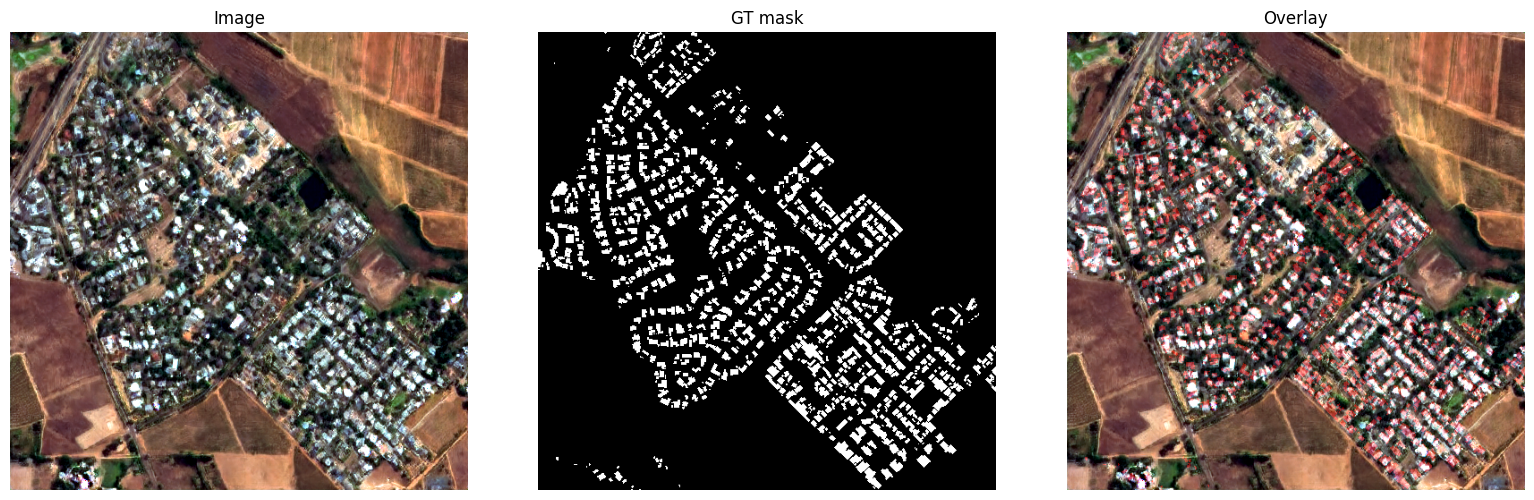

In [4]:
def rasterize_buildings(footprints_gdf, out_shape, transform, all_touched=False):
    if len(footprints_gdf) == 0:
        return np.zeros(out_shape, dtype=np.uint8)

    shapes_ = [(geom, 1) for geom in footprints_gdf.geometry]
    mask = rasterize(
        shapes=shapes_,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8,
        all_touched=all_touched
    )
    return mask


H, W = img.shape[:2]
gt_mask = rasterize_buildings(
    footprints, (H, W), transform,
    all_touched=RASTERIZE_ALL_TOUCHED
)

if LABEL_DILATE_PIXELS > 0:
    k = 2*LABEL_DILATE_PIXELS + 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    gt_mask = cv2.dilate(gt_mask, kernel, iterations=1)

coverage = 100.0 * gt_mask.mean()
print(f"✅ Ground-truth mask ready. Coverage={coverage:.2f}%")

# Visual check
plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gt_mask, cmap="gray"); plt.title("GT mask"); plt.axis("off")
overlay = img.copy()
overlay[gt_mask > 0, 0] = np.clip(overlay[gt_mask > 0, 0] + 0.4, 0, 1)
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.tight_layout()
plt.show()

if gt_mask.sum() == 0:
    raise RuntimeError("No buildings found in this area (GT mask is empty). Try bigger BUFFER_DEG or different image.")


✅ Sampled patches: 720 / requested 1200
Train: (576, 256, 256, 3) (576, 256, 256, 1)
Val  : (144, 256, 256, 3) (144, 256, 256, 1)


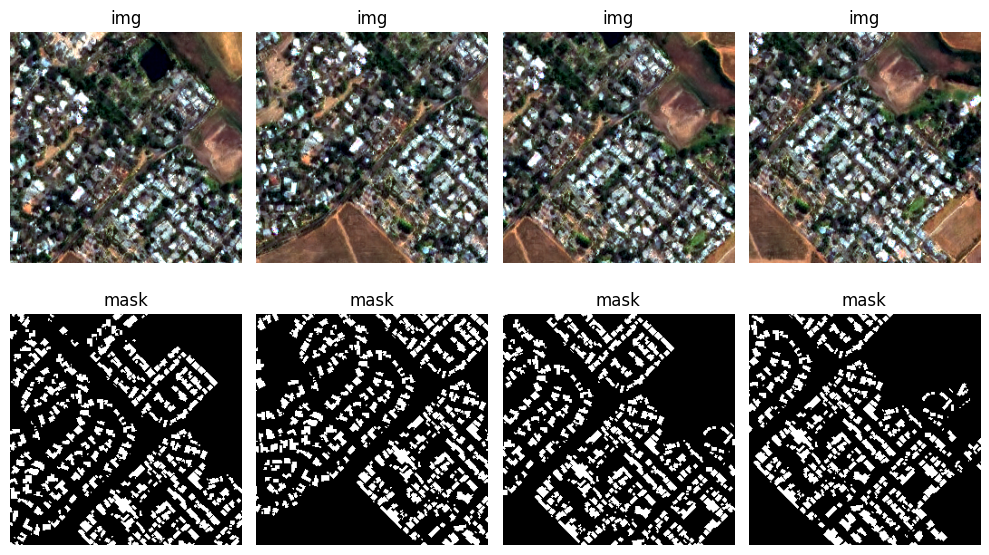

In [5]:
def sample_patches_balanced(img, mask, patch_size, n_patches,
                            pos_fraction=0.6,
                            min_pos_ratio=0.01,
                            max_neg_ratio=0.001,
                            max_tries=200000,
                            seed=42):
    """
    Balanced patch sampling:
      - positive patches centered near building pixels
      - negative patches mostly background
    This strongly reduces false positives vs sampling only positive patches.
    """
    rng = np.random.default_rng(seed)
    H, W = mask.shape
    ps = patch_size

    if H < ps or W < ps:
        raise ValueError(f"Image too small for patch_size={ps}. Got {H}x{W}.")

    ys, xs = np.where(mask > 0)
    has_pos = len(xs) > 0

    X, Y = [], []
    n_pos = int(n_patches * pos_fraction)
    n_neg = n_patches - n_pos

    def clip_xy(cx, cy):
        x0 = int(np.clip(cx - ps//2, 0, W-ps))
        y0 = int(np.clip(cy - ps//2, 0, H-ps))
        return x0, y0

    tries = 0
    # Positive patches
    while len(X) < n_pos and tries < max_tries:
        tries += 1
        if not has_pos:
            break
        i = rng.integers(0, len(xs))
        cx, cy = xs[i], ys[i]
        x0, y0 = clip_xy(cx, cy)
        pm = mask[y0:y0+ps, x0:x0+ps]
        ratio = pm.mean()
        if ratio >= min_pos_ratio:
            X.append(img[y0:y0+ps, x0:x0+ps])
            Y.append(pm[..., None])

    # Negative patches
    while len(X) < n_pos + n_neg and tries < max_tries:
        tries += 1
        x0 = rng.integers(0, W-ps+1)
        y0 = rng.integers(0, H-ps+1)
        pm = mask[y0:y0+ps, x0:x0+ps]
        ratio = pm.mean()
        if ratio <= max_neg_ratio:
            X.append(img[y0:y0+ps, x0:x0+ps])
            Y.append(pm[..., None])

    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y, dtype=np.float32)
    print(f"✅ Sampled patches: {len(X)} / requested {n_patches}")
    if len(X) < max(100, n_patches//5):
        print("⚠️ Too few patches sampled. Try:")
        print("  - lower MIN_POS_RATIO / increase MAX_NEG_RATIO")
        print("  - increase BUFFER_DEG")
        print("  - increase N_PATCHES")
    return X, Y


X, Y = sample_patches_balanced(
    img, gt_mask,
    patch_size=PATCH_SIZE,
    n_patches=N_PATCHES,
    pos_fraction=POS_FRACTION,
    min_pos_ratio=MIN_POS_RATIO,
    max_neg_ratio=MAX_NEG_RATIO,
    seed=SEED
)

# Train/val split
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8 * len(X))
train_idx, val_idx = idx[:split], idx[split:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]

print("Train:", X_train.shape, Y_train.shape)
print("Val  :", X_val.shape, Y_val.shape)

# Quick sanity plot
plt.figure(figsize=(10,6))
for i in range(4):
    j = np.random.randint(0, len(X_train))
    plt.subplot(2,4,i+1); plt.imshow(X_train[j]); plt.axis("off"); plt.title("img")
    plt.subplot(2,4,4+i+1); plt.imshow(Y_train[j].squeeze(), cmap="gray"); plt.axis("off"); plt.title("mask")
plt.tight_layout()
plt.show()


In [6]:
def augment_pair(x, y):
    # random flips
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x); y = tf.image.flip_left_right(y)
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x); y = tf.image.flip_up_down(y)

    # random 90-degree rotations
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k); y = tf.image.rot90(y, k)

    # photometric jitter (image only)
    x = tf.image.random_brightness(x, max_delta=0.08)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    x = tf.clip_by_value(x, 0.0, 1.0)

    return x, y


def make_dataset(X, Y, batch_size, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if training:
        ds = ds.shuffle(len(X), seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(augment_pair, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_dataset(X_train, Y_train, BATCH_SIZE, training=True)
val_ds = make_dataset(X_val, Y_val, BATCH_SIZE, training=False)

print("✅ Datasets ready")


✅ Datasets ready


In [7]:
def conv_block(x, filters, dropout=0.0):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x


def build_unet(input_shape=(256,256,3), base=32):
    inp = layers.Input(shape=input_shape)

    c1 = conv_block(inp, base, dropout=0.0)
    p1 = layers.MaxPool2D()(c1)

    c2 = conv_block(p1, base*2, dropout=0.0)
    p2 = layers.MaxPool2D()(c2)

    c3 = conv_block(p2, base*4, dropout=0.1)
    p3 = layers.MaxPool2D()(c3)

    c4 = conv_block(p3, base*8, dropout=0.2)
    p4 = layers.MaxPool2D()(c4)

    b  = conv_block(p4, base*16, dropout=0.3)

    u4 = layers.UpSampling2D()(b)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, base*8, dropout=0.2)

    u3 = layers.UpSampling2D()(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, base*4, dropout=0.1)

    u2 = layers.UpSampling2D()(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, base*2, dropout=0.0)

    u1 = layers.UpSampling2D()(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, base, dropout=0.0)

    out = layers.Conv2D(1, 1, activation="sigmoid")(c8)
    return Model(inp, out)


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * inter + smooth) / (denom + smooth)


def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1.0 - dice_coef(y_true, y_pred))


model = build_unet((PATCH_SIZE, PATCH_SIZE, 3), base=32)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=bce_dice_loss,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="acc"),
        tf.keras.metrics.BinaryIoU(threshold=0.5, name="iou"),
        dice_coef
    ]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,855,489 (29.97 MB)

 Trainable params: 7,849,601 (29.94 MB)

 Non-trainable params: 5,888 (23.00 KB)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - acc: 0.6914 - dice_coef: 0.3670 - iou: 0.4736 - loss: 1.2906 - val_acc: 0.8229 - val_dice_coef: 0.2444 - val_iou: 0.4114 - val_loss: 1.3068 - learning_rate: 1.0000e-04
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - acc: 0.8102 - dice_coef: 0.4092 - iou: 0.5850 - loss: 1.0377 - val_acc: 0.8229 - val_dice_coef: 0.2125 - val_iou: 0.4114 - val_loss: 1.2602 - learning_rate: 1.0000e-04
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - acc: 0.8249 - dice_coef: 0.4346 - iou: 0.6054 - loss: 0.9729 - val_acc: 0.8229 - val_dice_coef: 0.1865 - val_iou: 0.4114 - val_loss: 1.2713 - learning_rate: 1.0000e-04
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - acc: 0.8353 - dice_coef: 0.4573 - iou: 0.6225 - loss: 0.9301 - val_acc: 0.8234 - val_dice_coef: 0.1774 - val_iou: 0.4145 - val_loss: 1.2761 - learning_rate: 1.0000e-04
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - acc: 0.8437 - dice_coef: 0.4752 - iou: 0.6360 - loss: 0.8965 - 

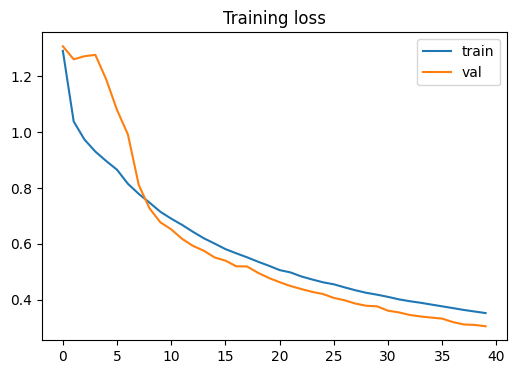

✅ Best threshold on VAL: 0.450 (F1=0.869)


In [8]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6, monitor="val_loss")
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Training loss")
plt.legend()
plt.show()


def compute_metrics_binary(y_true, y_pred_bin):
    y_true = (y_true > 0.5).astype(np.uint8).reshape(-1)
    y_pred = (y_pred_bin > 0).astype(np.uint8).reshape(-1)

    tp = np.sum((y_true==1) & (y_pred==1))
    fp = np.sum((y_true==0) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    tn = np.sum((y_true==0) & (y_pred==0))

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2*precision*recall / (precision + recall + 1e-8)
    iou       = tp / (tp + fp + fn + 1e-8)
    dice      = (2*tp) / (2*tp + fp + fn + 1e-8)
    return dict(tp=tp, fp=fp, fn=fn, tn=tn, precision=precision, recall=recall, f1=f1, iou=iou, dice=dice)


# Auto-tune threshold using val patches (big improvement)
val_probs = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)

best_t, best_f1 = 0.5, -1
for t in np.linspace(0.2, 0.8, 13):
    m = compute_metrics_binary(Y_val, (val_probs > t).astype(np.uint8))
    if m["f1"] > best_f1:
        best_f1, best_t = m["f1"], t

PRED_THRESHOLD = float(best_t)
print(f"✅ Best threshold on VAL: {PRED_THRESHOLD:.3f} (F1={best_f1:.3f})")


✅ prob_map: (512, 512) 0.0 0.999998


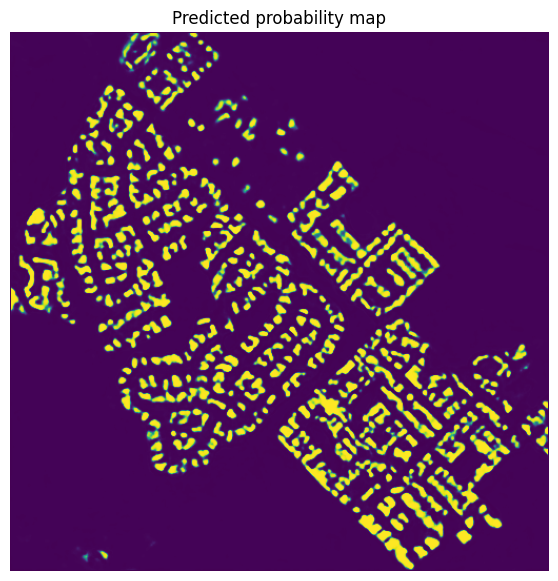

In [9]:
def hann2d(h, w):
    wy = np.hanning(h)
    wx = np.hanning(w)
    return np.outer(wy, wx).astype(np.float32)


def predict_full_image(model, img, tile=256, stride=128):
    H, W = img.shape[:2]
    pad_h = (tile - (H % stride)) % stride
    pad_w = (tile - (W % stride)) % stride

    img_pad = np.pad(img, ((0,pad_h),(0,pad_w),(0,0)), mode="reflect")
    Hp, Wp = img_pad.shape[:2]

    weight = hann2d(tile, tile)
    prob_sum = np.zeros((Hp, Wp), dtype=np.float32)
    w_sum = np.zeros((Hp, Wp), dtype=np.float32)

    ys = list(range(0, Hp - tile + 1, stride))
    xs = list(range(0, Wp - tile + 1, stride))
    if ys[-1] != Hp - tile: ys.append(Hp - tile)
    if xs[-1] != Wp - tile: xs.append(Wp - tile)

    for y0 in ys:
        for x0 in xs:
            patch = img_pad[y0:y0+tile, x0:x0+tile]
            pred = model.predict(patch[None,...], verbose=0)[0,...,0]
            prob_sum[y0:y0+tile, x0:x0+tile] += pred * weight
            w_sum[y0:y0+tile, x0:x0+tile] += weight

    prob = prob_sum / (w_sum + 1e-8)
    return prob[:H, :W]


prob_map = predict_full_image(model, img, tile=TILE_SIZE, stride=STRIDE)
print("✅ prob_map:", prob_map.shape, prob_map.min(), prob_map.max())

plt.figure(figsize=(7,7))
plt.imshow(prob_map, cmap="viridis")
plt.title("Predicted probability map")
plt.axis("off")
plt.show()


✅ Final binary mask. Components=287


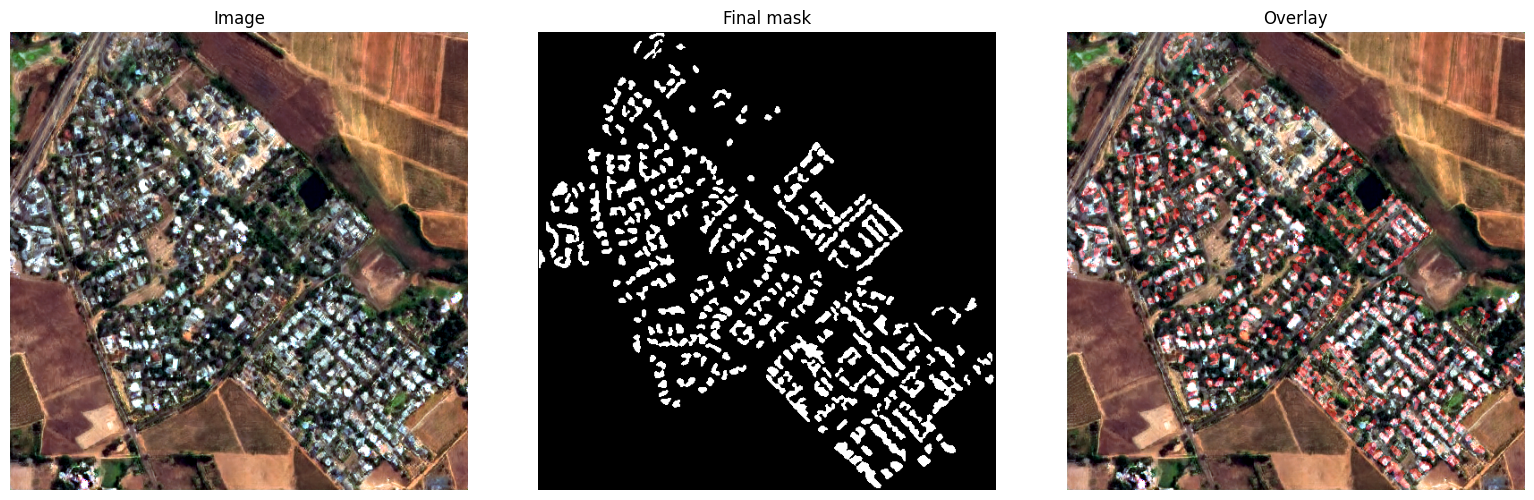

In [10]:
def postprocess(prob, threshold, min_obj=40, hole_size=80,
                use_watershed=True, min_distance=6):
    binm = (prob >= threshold)

    # remove tiny speckles / fill holes
    binm = remove_small_objects(binm, min_size=min_obj)
    binm = remove_small_holes(binm, area_threshold=hole_size)

    binm_u8 = binm.astype(np.uint8)

    if not use_watershed:
        return binm_u8

    # Watershed split (optional)
    dist = ndi.distance_transform_edt(binm_u8)
    peaks = peak_local_max(dist, min_distance=min_distance, labels=binm_u8)
    markers = np.zeros_like(binm_u8, dtype=np.int32)
    for i, (r, c) in enumerate(peaks, start=1):
        markers[r, c] = i

    if markers.max() < 2:
        # no meaningful split
        return binm_u8

    labels = watershed(-dist, markers, mask=binm_u8)
    out = (labels > 0).astype(np.uint8)

    # cleanup again
    out = remove_small_objects(out.astype(bool), min_size=min_obj).astype(np.uint8)
    return out


pred_mask = postprocess(
    prob_map, threshold=PRED_THRESHOLD,
    min_obj=MIN_OBJECT_PIXELS,
    hole_size=HOLE_PIXELS,
    use_watershed=USE_WATERSHED_SPLIT,
    min_distance=WATERSHED_MIN_DISTANCE
)

n_components = ndi.label(pred_mask)[1]
print(f"✅ Final binary mask. Components={n_components}")

# Visualization
plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pred_mask, cmap="gray"); plt.title("Final mask"); plt.axis("off")
overlay = img.copy()
overlay[pred_mask > 0, 0] = np.clip(overlay[pred_mask > 0, 0] + 0.4, 0, 1)
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.tight_layout()
plt.show()


In [11]:
# --- Export GeoTIFFs ---
prob_tif = os.path.join(OUTPUT_DIR, "buildings_prob.tif")
mask_tif = os.path.join(OUTPUT_DIR, "buildings_mask.tif")

prob_profile = profile.copy()
prob_profile.update(count=1, dtype="float32", nodata=0)

mask_profile = profile.copy()
mask_profile.update(count=1, dtype="uint8", nodata=0)

with rasterio.open(prob_tif, "w", **prob_profile) as dst:
    dst.write(prob_map.astype(np.float32), 1)

with rasterio.open(mask_tif, "w", **mask_profile) as dst:
    dst.write(pred_mask.astype(np.uint8), 1)

print("✅ Saved:", prob_tif)
print("✅ Saved:", mask_tif)


# --- Vectorize to GeoJSON ---
def estimate_utm_crs_from_bounds(bounds_wgs84):
    west, south, east, north = bounds_wgs84
    lon = (west + east) / 2
    lat = (south + north) / 2
    zone = int((lon + 180) / 6) + 1
    epsg = 32600 + zone if lat >= 0 else 32700 + zone
    return CRS.from_epsg(epsg)


geojson_path = os.path.join(OUTPUT_DIR, "buildings.geojson")

# vectorize connected components
shapes_gen = features.shapes(pred_mask.astype(np.uint8), transform=transform)
geoms = []
vals = []
for geom, val in shapes_gen:
    if val == 1:
        geoms.append(shape(geom))
        vals.append(val)

gdf = gpd.GeoDataFrame({"geometry": geoms}, crs=crs)

# drop tiny polygons using metric area (UTM) if possible
try:
    west, south, east, north = bounds_to_wgs84(bounds, crs)
    utm = estimate_utm_crs_from_bounds((west, south, east, north))
    gdf_m = gdf.to_crs(utm)
    gdf["area_m2"] = gdf_m.area
    gdf = gdf[gdf["area_m2"] > 10]  # keep only polygons > 10m² (adjust)
except Exception as e:
    print("⚠️ Could not compute m² area (CRS issue):", e)

# optional simplify to reduce vertices
gdf["geometry"] = gdf.geometry.simplify(tolerance=0.3, preserve_topology=True)

gdf.to_file(geojson_path, driver="GeoJSON")
print(f"✅ Saved GeoJSON: {geojson_path} (polygons={len(gdf)})")

gdf.head()


✅ Saved: outputs\buildings_prob.tif
✅ Saved: outputs\buildings_mask.tif
✅ Saved GeoJSON: outputs\buildings.geojson (polygons=287)


geometry  area_m2
0  POLYGON ((301748.532 6240336.447, 301748.532 6...   412.50
1  POLYGON ((301813.532 6240306.447, 301813.532 6...   275.00
2  POLYGON ((301701.032 6240313.947, 301701.032 6...   356.25
3  POLYGON ((301758.532 6240318.947, 301758.532 6...   856.25
4  POLYGON ((301853.532 6240246.447, 301853.532 6...   275.00

📊 FULL IMAGE METRICS
 precision: 0.8726
    recall: 0.8039
        f1: 0.8368
       iou: 0.7194
      dice: 0.8368
TP/FP/FN: 25628 3742 6253


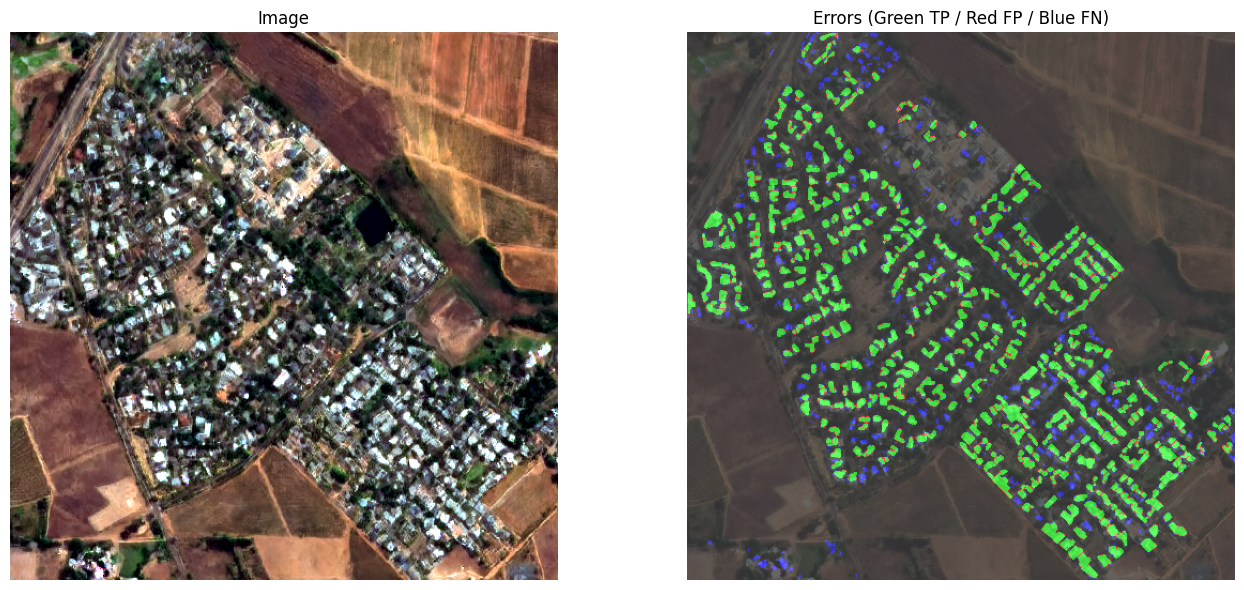

In [12]:
metrics_full = compute_metrics_binary(gt_mask[...,None], pred_mask[...,None])
print("📊 FULL IMAGE METRICS")
for k in ["precision","recall","f1","iou","dice"]:
    print(f"{k:>10}: {metrics_full[k]:.4f}")
print("TP/FP/FN:", metrics_full["tp"], metrics_full["fp"], metrics_full["fn"])

# Error map visualization
y_true = (gt_mask > 0)
y_pred = (pred_mask > 0)

err = np.zeros((H, W, 3), dtype=np.uint8)
err[(y_true) & (y_pred)] = [0,255,0]   # TP green
err[(~y_true) & (y_pred)] = [255,0,0]  # FP red
err[(y_true) & (~y_pred)] = [0,0,255]  # FN blue

plt.figure(figsize=(14,6))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img, alpha=0.5); plt.imshow(err, alpha=0.6)
plt.title("Errors (Green TP / Red FP / Blue FN)"); plt.axis("off")
plt.tight_layout()
plt.show()
